# Testing PyStan and Pyro for base workflow

In [ ]:
# Uncomment to install
!pip install pyro-ppl "pystan<3"

In [26]:
# pystan
import pystan

In [27]:
# pyro-ppl
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [28]:
# torch
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.distributions.constraints as constraints

In [29]:
# stats and standard
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.model_selection import GridSearchCV, ShuffleSplit
import scipy.stats.kde as kde

In [39]:
# high-performance
import dask
import arrow
import jax.numpy as jnp
from jax import random, pmap

# MCMC samples from Stan

In [32]:
# setting up data
theta = 0.6
n = 1000
y = stats.bernoulli.rvs(theta, size=n)

In [33]:
# stan model definition
model_code = """
data {
    int<lower=0> n;
    int y[n];
}
parameters {
    real<lower=0, upper=1> theta;
}
model {
    // model likelihood:
    y ~ bernoulli(theta);
    // model prior:
    theta ~ beta(0.5, 0.5);
}
"""

In [34]:
#compile model
stan_model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0dceae92b86d1c822297182f28329dd9 NOW.


In [35]:
#model fit sampling
data_dict = {'y' : y, 'n' : n}
fit = stan_model.sampling(data=data_dict, iter=1000, chains=4)

In [36]:
#samples
theta = fit.extract(permuted=True)['theta']

In [45]:
#print and plot
print("Samples:", theta[:10])
print("Mean:", jnp.mean(theta, axis=0))
print("Standard deviation:", jnp.std(theta, axis=0))

Samples: [0.61111193 0.59845556 0.60859396 0.5940438  0.62126958 0.61966241
 0.59539719 0.58755612 0.65078529 0.62099168]
Mean: 0.6089436
Standard deviation: 0.015051828


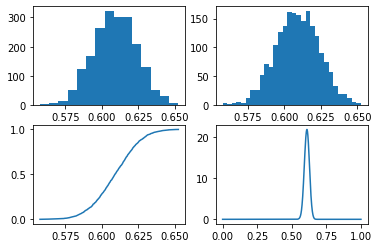

In [52]:
# histogram
_, ax = plt.subplots(2, 2)
ax[0, 0].hist(theta, 15)
ax[0, 1].hist(theta, 30)
# empirical cumulative distribution
ecdf = ECDF(theta)
ax[1, 0].plot(ecdf.x, ecdf.y)
# density estimation using KDE (with tuning parameter chosen 3 fold CV)
params_kde = {'bandwidth' : np.logspace(-2, 3, 10)}
grid = GridSearchCV(KernelDensity(), params_kde, cv=3)
grid.fit(theta.reshape(-1, 1))
x_kde = np.linspace(0, 1, 10000).reshape(-1, 1)
y_kde = np.exp(grid.best_estimator_.score_samples(x_kde))
ax[1, 1].plot(x_kde, y_kde)

# MCMC samples from Pyro

In [85]:
# data
y_tensor = torch.as_tensor(y, dtype=torch.float32)

In [88]:
# model pyro

def model(y_tensor):
    prior_dist = dist.Beta(torch.Tensor([.5]), torch.Tensor([.5]))
    theta = pyro.sample('theta', prior_dist)
    with pyro.plate('observed_data'):
        pyro.sample('obs', dist.Bernoulli(theta), obs=y_tensor)

In [89]:
# Use NUTS or HMC sampler
nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=300)
mcmc.run(y_tensor)

Sample: 100%|██████████| 800/800 [00:10, 75.39it/s, step size=8.23e-01, acc. prob=0.945] 


In [66]:
# samples
posterior_simulations = mcmc.get_samples()['theta'].numpy().ravel()

In [67]:
# print
print("Some samples:", posterior_simulations[:6])
print("Mean:", posterior_simulations.mean())
print("Standard deviation:", posterior_simulations.std())

Some samples: [0.61350656 0.61331743 0.61367345 0.61359006 0.61379653 0.6136473 ]
Mean: 0.61009777
Standard deviation: 0.0020661987


# Replications of data from MCMC samples

In [59]:
replication = stats.bernoulli.rvs(posterior_simulations)

In [68]:
print("P(Y=0|D) = ", (replications == 0).mean())
print("P(Y=1|D) = ", (replications == 1).mean())

P(Y=0|D) =  0.382
P(Y=1|D) =  0.618


# Stochastic variational inference in Pyro for ABC

In [69]:
# defining guide (inference parameters) for the model defined above
def guide(y_tensor):
    alpha = pyro.param("alpha", torch.Tensor([1.0]),
                      constraint=constraints.positive)
    beta = pyro.param("beta", torch.Tensor([1.0]),
                     constraint=constraints.positive)
    theta = pyro.sample('theta', dist.Beta(alpha, beta))

In [70]:
# Setting up optimizer for inference
pyro.clear_param_store()
adam_params = {"lr": 0.2, "betas": (0.9, 0.999)}
optimizer = Adam(adam_params)

In [74]:
# Setting up SVI
svi_abc = SVI(model, guide, optimizer, loss=Trace_ELBO())
# gradient steps
n_steps = 100
for step in range(n_steps):
    svi.step(y_tensor)

In [75]:
# pyro parameters
alpha = pyro.param("alpha").item()
beta = pyro.param("beta").item()

In [76]:
# distribution from samples
inf_distribution = stats.beta(alpha, beta)

In [77]:
print("Some samples:", inf_distribution.rvs(6))
print("Mean:", inf_distribution.mean())
print("Standard deviation:", inf_distribution.std())

Some samples: [0.67084975 0.6148679  0.73944176 0.70727039 0.60213527 0.57437472]
Mean: 0.6289155085169171
Standard deviation: 0.0694105727764976


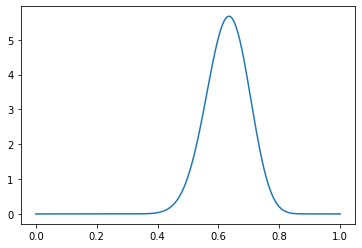

In [78]:
# plotting the posterior
x_svi = np.linspace(0, 1, 10000)
y_svi = inf_distribution.pdf(x_svi)
plt.plot(x_svi, y_svi)


In [79]:
# replication check
replications = stats.bernoulli.rvs(inf_distribution.rvs(1000))
print("-"*50)
print("P(Y=0|D) =", (replications == 0).mean())
print("P(Y=1|D) =", (replications == 1).mean())



--------------------------------------------------
P(Y=0|D) = 0.342
P(Y=1|D) = 0.658
